Smoking behaviour
-----------------------------
- questionnaire on every evening 
- number of cig smoked during the day
- yes/no stub out cig before finishing it in order to smoke less
- yes/no stop yourself having a cig to smoke less
- if zero cig, ask why

Following study hypotheses we want here to look at micro-indicators of behaviour change, including: 
- being more likely to report making a quit attempt over the 4-week period;
- more frequently reporting forgoing cigarettes over the 4-week period;
- a greater intention to quit smoking at the end of the 4-week period;
- a reduction in the number of cigarettes smoked over the 4-week period. 

Participants who report not smoking any cigarettes on at least one of the study days and report this being because they were trying to quit smoking will be considered having made a quit attempt during the study period. 

CPD will be assessed using the daily smoked cigarette reports completed in the evening report. We anticipate that any decrease in reporting cigarettes smoked over the study period will be the same between the two conditions. We will exclude data collected on the baseline day (Day 0) and the final day (Day 28: Table 2) as participants will start and end the study at different times during those days.

    • model for quit attempts: quit_attempt ~ time + condition + (1 + time|subject)
    • model for forgoing cigarettes: FC ~ time + condition + (1 + time|subject)
    • model for intention to quit: quit_intention ~ time + condition + (1 + time|subject)
    • model for CPD: CPD ~ time + condition + (1 + time|subject)

# Preprocessing data


In [1]:
library(tidyverse)
library(here)
library(lubridate)


cond_file = "~/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/expe_condition_final.csv"


save_figure = here::here("Figures")

files_eff_eve <-dir(path=here::here("data") , pattern = "*.csv") 

evening_scores <-read.csv(here::here("data", files_eff_eve), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

# condition file
cond <- read_csv(cond_file)

# rename columns
# 1 = Yes, 2 =No

evening_scores<-rename(evening_scores, date=EndDate, completed=Finished,
                      ID=Q1, 
                      NCig=Q4, 
                      StubCig=Q5, 
                      StopCig=Q6, 
                      WhyNoCig=Q7,
                      WhyNoCig_other=Q7_5_TEXT
                      )



# select only columns of interest

evening_scores<-select(evening_scores, ID, date, completed,
                       NCig, StubCig, StopCig,
                      WhyNoCig, WhyNoCig_other)

#remove additional header
evening_scores<-tail(evening_scores, -2)


# get the experiment condition file with all pp IDs
cond <-rename(cond, ID = "Subject ID", 
              condition = "Condition = Intervention",
              removed= "REMOVED")
cond$ID<-as.factor(cond$ID)

evening_scores$ID<-as.factor(evening_scores$ID)
tmp<-full_join(cond, evening_scores)

remove(evening_scores)
evening_scores<-tmp
evening_scores$ID<-as.factor(evening_scores$ID)

#recode condition to human names
evening_scores$condition<-recode(evening_scores$condition, '0' = "control", '1' = "intervention")

#Replace missing values and keep only participants who were not removed
evening_scores$removed<-evening_scores$removed %>% replace(is.na(.), 0)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /home/claire/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/Cig_per_day


Attaching package: ‘lubridate’


The following object is masked from ‘package:here’:

    here


The following object is masked from ‘package:base’:

    date


Parsed with column specification:
cols(
  `Subject ID` = col_double(),
  day_msg = col_double(),
  `Starting Date` = col_character(),
  Good = col_double(),
  `Condition = Intervention` = col_double(),
  EEG = col_double(),
  Finished = col_double(),
  REMOVED = col_double(),
  Interview = col_double(),
  Notes = col_character(),
  `No Compliance` = col_do

In [ ]:
# remove NA in  scores
#which(is.na(evening_scores$StubCig))

#evening_scores<-drop_na(evening_scores, StubCig)

In [2]:
# remove lines not associated with a real participant ID
which(is.na(evening_scores$condition))

evening_scores<-drop_na(evening_scores, condition)

[1] 5705 5706 5707 5708 5709 5710 5711 5712 5713 5714 5715 5716 5717 5718 5719
[16] 5720 5721 5722 5723 5724 5725 5726 5727 5728 5729 5730 5731 5732 5733 5734
[31] 5735 5736 5737 5738 5739 5740 5741 5742 5743 5744 5745 5746 5747 5748 5749
[46] 5750 5751 5752 5753 5754 5755 5756 5757 5758 5759 5760 5761 5762 5763 5764
[61] 5765

In [3]:
# filter to keep participants who did at least 80% of surveys
evening_scores<-evening_scores%>%filter(Good == 1)

In [4]:
df<-evening_scores

In [5]:
df$NCig <- as.numeric(df$NCig)
df$StubCig<- as.numeric(df$StubCig)
df$StopCig<- as.numeric(df$StopCig)

#which(is.na(df$NCig))
#df<-drop_na(df,NCig)

In [ ]:
df

In [ ]:
colnames(df)

In [6]:
df<-select(df, -'removed', -'Finished', -'Interview', -'Notes', -"completed" )
df<-select(df, -'Starting Date', -'day_msg',  -'No Compliance', -'Email reminder poor perf', -'eve_msg', -'ev3days')

In [7]:
df <-df %>% 
  group_by(ID) %>% 
  mutate(n_day = row_number()) %>%
  select(ID, n_day, everything()) %>% 
  ungroup()  


In [8]:
# create factor time
df$n_day<-as.factor(df$n_day)

In [ ]:
levels(df$n_day)

In [9]:
# remove days > 28 - might need to look into that later
df<-df[! df$n_day %in% c("29", "30",  '30', '31', '32', '33', '34', '35'),]

In [10]:
df$condition<-as.factor(df$condition)

In [11]:
df<-df %>% group_by(condition) %>% 
mutate(n_pp=n_distinct(ID)) %>% 
    ungroup()

Saving 6.67 x 6.67 in image



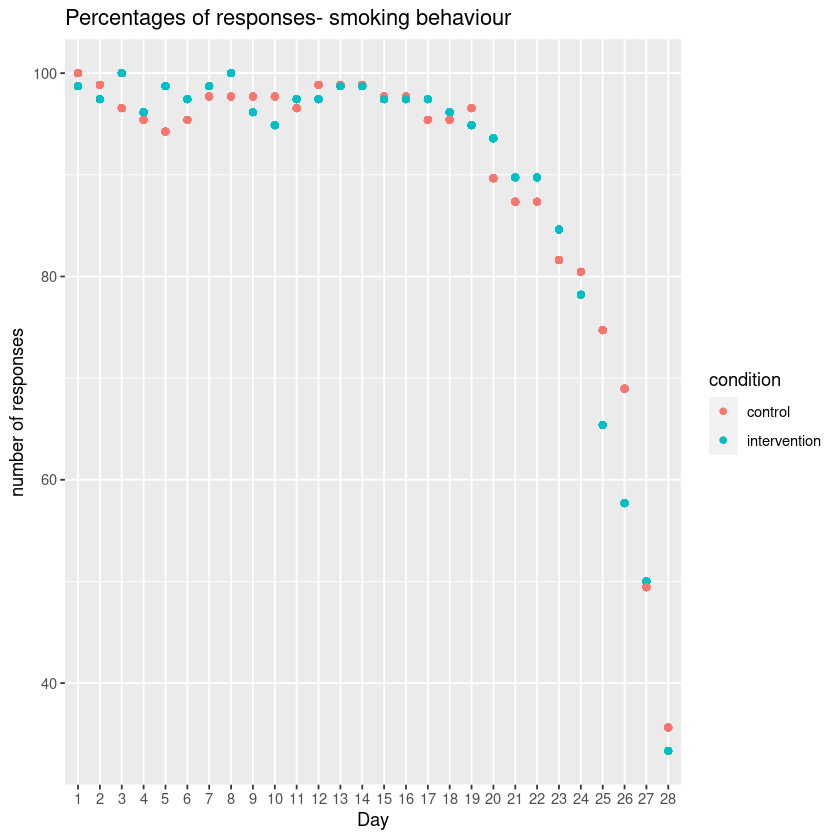

In [20]:
# count how many of each day per condition (ie.did the pp completed the survey)
n_rep <- df %>% group_by(condition, n_day) %>%
 mutate(count=sum(!is.na(NCig))) %>% 
    ungroup()
n_rep <-n_rep %>% drop_na()

#n_rep$EEG<-as.factor(n_rep$EEG)

# plot
ggplot(data= n_rep, aes(x = n_day, y=count/n_pp*100) ) +
  geom_point(mapping = aes(colour = condition) ) +
  ggtitle("Percentages of responses- smoking behaviour")+
  xlab('Day')+ ylab('number of responses')#+ 
 ggsave('percent_resp_per_day_all.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

Saving 6.67 x 6.67 in image



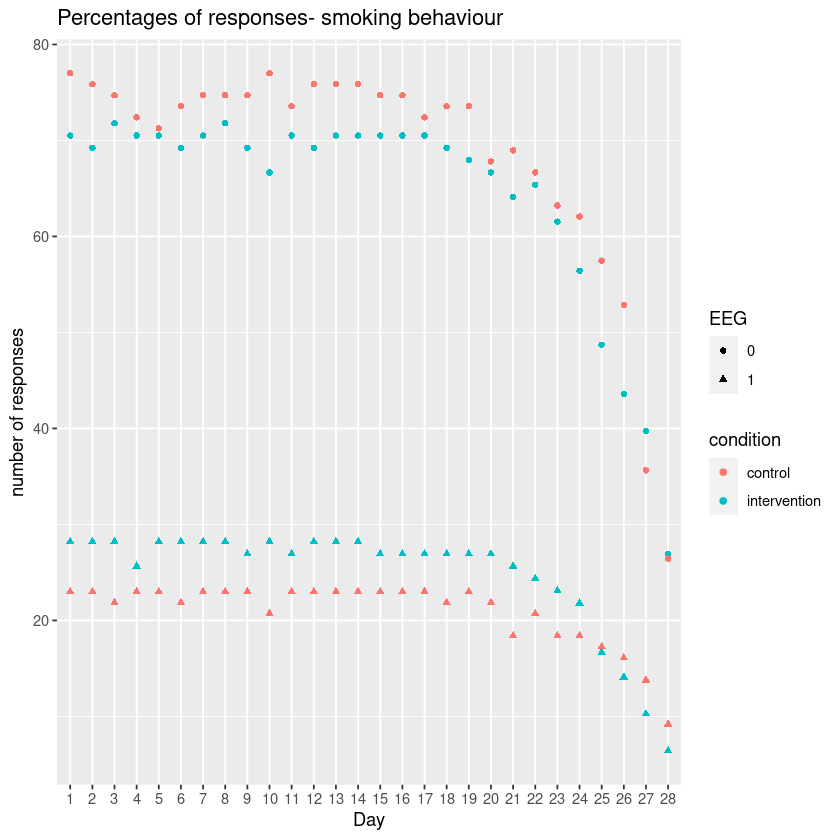

In [22]:
# count how many of each day per condition
n_rep <- df %>% group_by(condition, n_day, EEG) %>%
  mutate(count=sum(!is.na(NCig))) %>% 
    ungroup()
n_rep <-n_rep %>% drop_na()

n_rep$EEG<-as.factor(n_rep$EEG)

# plot
ggplot(data= n_rep, aes(x = n_day, y=count/n_pp*100)) +
  geom_point(mapping = aes(colour = condition, shape=EEG) ) +
  ggtitle("Percentages of responses- smoking behaviour")+
  xlab('Day')+ ylab('number of responses')#+ 
 ggsave('percent_resp_per_day_all_eeg.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

## Now check for anomalies in how data were entered


In [ ]:
# check for outliers/anomalie data -> check if mistake on 1 day
df %>% filter(NCig>50) # 50 as a guess 


Seems to be an error where the participant's ID was entered instead of the number of cig smoked on at least one occasion

In [ ]:
# replace these aberrant values by NA
df$NCig<-replace(df$NCig, df$NCig>50, NA)

# Reports of 0 cigarettes smoked on a day

Follow-up question: Why did you not smoke any cigarettes today?
Value for numeric responses:
- 1= I didn't have time
- 2= I didn't feel like smoking
- 3= I was in places where smoking was not allowed
- 4= I am trying to stop smoking
- 5 = others (see WhyNoCig_other)

"Participants who report not smoking any cigarettes on at least one of the study days and report this being because they were trying to quit smoking will be considered having made a quit attempt during the study period. "

In [ ]:
# how many reported no cig on at least one day
test<-df %>% filter(NCig==0)  
n_distinct(test$ID)

In [ ]:
# how many reported no cig because want to stop smoking
test<-test %>% filter(WhyNoCig ==4)
n_distinct(test$ID)

In [ ]:
distinct(test, ID, `.keep_all` = TRUE) %>% filter(condition=='control')

## Conclusion

12 participants reported not smoking any cigarette on at least one of the study days. Out of these, 9 reported not smoking because they were trying to quit smoking = made a quit attempt (6 were in the intervention group, 3 in the control group).

# Reports of forgoing cigarettes 


H3: As compared to those in the control condition, those in the efficacy condition will display micro-indicators of behaviour change, including:  
 - more frequently reporting forgoing cigarettes (FC) over the 4-week period;  

Forgoing = forgoing stub + forgoing stop

Response code:
- 1 = yes
- 2 = no




How many forego in each condition?

In [ ]:
df %>% group_by(condition) %>% 
summarise(sum(StopCig==1, na.rm=TRUE), 
         sum(StubCig==1, na.rm=TRUE))

In [ ]:
df_long<-pivot_longer(df, cols=starts_with("St"), names_to = "ForegoCig", 
             values_to = "NCigForego")

In [ ]:
df_long$NCigForego<-as.factor(df_long$NCigForego)

In [ ]:
df_long %>% group_by(condition, n_day) %>% 
geom_freqpoly(mapping=aes(x=NCigForego))

In [ ]:
freq_forego<-df_long %>% filter(!is.na(NCigForego))  %>% 
    group_by(condition, n_day)  %>% 
count(NCigForego) %>% 
mutate(rel.freq= round(100*n/sum(n),0))


In [ ]:
freq_count<-df_long %>% filter(!is.na(NCigForego)) %>% 
        group_by(condition, n_day, NCigForego) %>% 
        tally()


In [ ]:
freq_forego 

In [ ]:
freq_forego %>% filter(NCigForego==1) %>% 
ggplot(aes(y=rel.freq, x=n_day, group=condition))+
geom_line(aes(linetype=condition))+
 geom_point(mapping = aes(colour = condition ) )+
ggtitle ("Foregoing cigarettes by group")+
ylab(" % reporting foregoing cig")+
xlab("Day of study")


In [ ]:
?density

In [ ]:
library(WRS2)
library(effsize)
library(rogme)
library(gridExtra)
library(cowplot)

In [ ]:
# plot
ggplot(data= test, aes(x = n_day, y=total_forgo)) +
  geom_point(mapping = aes(colour = condition) ) +
  ggtitle("Forgoing Cigarettes")+
  xlab('Day')+ ylab('n cig forgone')#+ 
 #ggsave('percent_resp_per_day_all_eeg.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

In [ ]:
# plot
ggplot(data= df, aes(x = n_day, y=NCig) ) +
  geom_point(mapping = aes(colour = condition) ) +
  ggtitle("Smoked Cig per day")+
  xlab('Day')+ ylab('n cig')#+ 
 #ggsave('percent_resp_per_day_all.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

In [ ]:
df2<-df

In [ ]:
df2$EEG<-as.factor(df2$EEG)

df2<-select(df2, -'n_pp')

In [ ]:
df2<-rename(df2, value_NCig=NCig, value_StubCig= StubCig, value_StopCig=StopCig)

In [ ]:
# turn df into long format 
df2_long<-df2 %>% 
  pivot_longer(
    -c('ID', 'condition', 'n_day', 'EEG', 'Good', 'date'),  
    names_to = c(".value", "score"), 
    names_sep = "_", 
    values_drop_na = TRUE
  )

df2_long$value<-as.numeric(df2_long$value)
df2_long$condition<-as.factor(df2_long$condition)

In [ ]:
df2_long

In [ ]:
# compute summary statistics per condition per day for each score
summary_df2<- df2_long %>%
  group_by(condition, n_day, score) %>%
  summarise(mean.total = mean(value, na.rm=TRUE),
            sd.total= sd(value, na.rm=TRUE), count = n(),
            se.mean = sd.total/sqrt(count), 
            ci.mean= qt(1-(1-0.95/2),count-1)*se.mean)

In [ ]:
summary_df2

In [ ]:
# N stub or stop cig per day
df_stop_stub<-summary_df2 %>% 
        filter(score=="StubCig" | score=='StopCig') 

ggplot(data=df_stop_stub, mapping=aes(x= n_day, y=mean.total)) +
      geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+ 
    facet_wrap(~score)+
       geom_errorbar(aes(ymin = mean.total - ci.mean, ymax = mean.total + ci.mean), 
                width=0.2)+
 theme(panel.spacing.x=unit(2, "cm"),panel.spacing.y=unit(1, "lines")) +
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Day")+ylab("Mean score")+
   ggtitle("Mean scores for stop/stub cigarettes per day")

  ggsave('stop_stub_per_day.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [ ]:
# N cig per day
df_ncig<-summary_df2 %>% 
        filter(score=="NCig") 

ggplot(data=df_ncig, mapping=aes(x= n_day, y=mean.total)) +
      geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+ 
    facet_wrap(~score)+
       geom_errorbar(aes(ymin = mean.total - ci.mean, ymax = mean.total + ci.mean), 
                width=0.2)+
 theme(panel.spacing.x=unit(2, "cm"),panel.spacing.y=unit(1, "lines")) +
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Measures")+ylab("Mean score")+
   ggtitle("Mean scores for cigarettes smoked per day")

  ggsave('cig_smoked_per_day.jpg', plot =last_plot(), dpi =300, path= save_figure)
